In [1]:
%run config.ipynb

In [2]:
# Connect to Cortex
cortex = Cortex.client()

In [3]:
# Our stock symbols
symbols = ['fb', 'xlf', 'aapl']
s = symbols[0]

In [4]:
print('Loading stock prices for %s' % s)
ds = cortex.dataset('demo/stock-prices-%s' % s)
c = ds.contract('stock-prices')

Loading stock prices for fb


In [5]:
df = c.load_feature_file(tag='prices_%s' % s)
df.tail()

,close
date,
2018-08-02,1.456182
2018-08-03,1.488092
2018-08-06,1.667103
2018-08-07,1.624557
2018-08-08,1.655561


In [6]:
from keras.models import load_model
model = load_model('model_stock_prices_%s.h5' % s)

Using TensorFlow backend.


In [7]:
# Load our scaler model so we can inverse the transform for visualization/validation
price_scaler = c.load_model_file(tag='prices_scaler_%s' % s)

In [8]:
look_back = 30
holdout_date = pd.to_datetime('2018-01-01')
predictors = ['close'] #, 'volume', 'spx_close', 'spx_volume', 'spx_pct_change']

In [9]:
def make_predictions(df, model):
    df['Pred'] = df.loc[df.index[0], 'close']
    for i in range(len(df.index)):
        if i <= look_back:
            continue
        a = None
        for p in predictors:
            b = df.loc[df.index[i-look_back:i], p].as_matrix()
            if a is None:
                a = b
            else:
                a = np.append(a,b)
            a = a
        y = model.predict(a.reshape(1,look_back*len(predictors),1))
        df.loc[df.index[i], 'Pred'] = y[0][0]

In [10]:
make_predictions(df, model)
df.loc[:, 'close'] = price_scaler.inverse_transform(df.loc[:, 'close'])
df.loc[:, 'Pred'] = price_scaler.inverse_transform(df.loc[:, 'Pred'])

In [11]:
# Save our predicted values
c.save_model_file(df, tag='prices_pred_%s' % s)

In [12]:
def plot_results(df, symbol, holdout_date=None):
    if holdout_date:
        train_df = df.loc[df.index < holdout_date]
        test_df = df.loc[df.index >= holdout_date]
    else:
        train_df = df
        test_df = df
    plt.rcParams['figure.figsize'] = [18,9]
    plt.plot(df.close, 'b', label = '%s Closing Price' % s.upper())
    plt.plot(train_df.Pred, 'r', label = 'Insample Prediction')
    plt.plot(test_df.Pred, 'g', label = 'Outsample Prediction')
    plt.title('LSTM Prediction of Closing Price for %s' % s.upper())
    plt.legend()
    plt.savefig('LSTM_Pred_%s.png' % s.upper())
    plt.show()

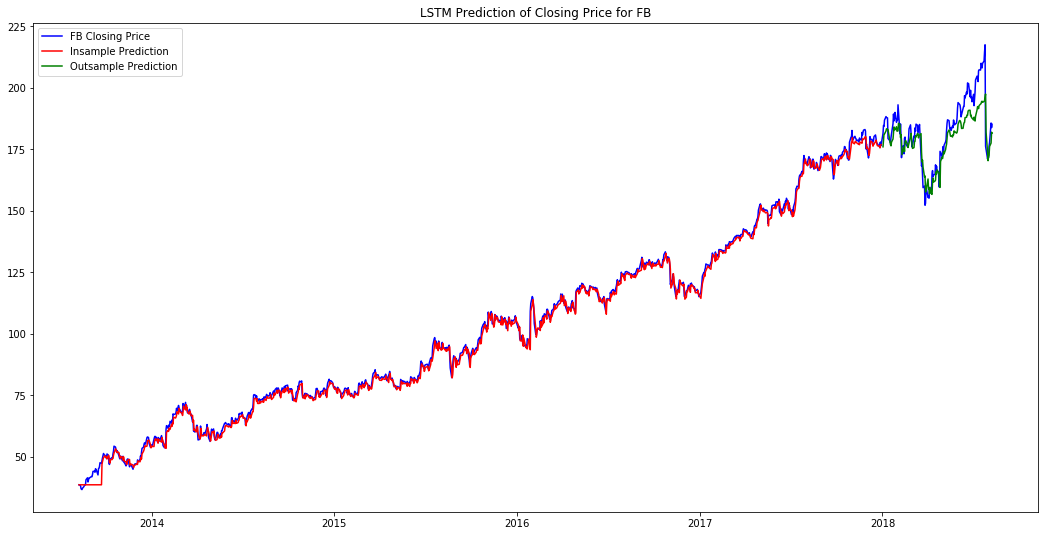

In [13]:
plot_results(df, s, holdout_date)